In [2]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader


import monai
from monai.transforms import LoadImage
from monai.config import print_config

from scripts.train import LitUnet
import pytorch_lightning as pl

from scripts.utils import *
from scripts.data import *

#print_config()

def display_subplot(data, title, ax, cmap="gray"):
    ax.imshow(data, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

def predict_and_display_examples(model, n, loader, centre, seed=0):
    torch.manual_seed(seed)
    batch = next(iter(loader))
    x, y = batch

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    x = x.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(x)
    prob = F.softmax(pred, dim=1)
    y_pred = torch.argmax(prob, dim=1).cpu()

    fig, axes = plt.subplots(3, 1, figsize=(n, 5))
    fig.suptitle(f"Image Predictions and Ground Truth for center {centre}", fontsize=16)
    
    display_subplot(rearrange(x.cpu()[:n+1], "b c h w -> h (b w) c"), "Images", axes[0])
    display_subplot(rearrange(y_pred[:n+1], "b h w -> h (b w)"), "Predictions", axes[1], cmap="viridis")
    display_subplot(rearrange(y[:n+1], "b h w -> h (b w)"), "Ground Truth", axes[2], cmap="viridis")

    plt.tight_layout()
    plt.show()

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root_directory = "Data/M&Ms/OpenDataset"
transform =  monai.transforms.ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)

train_dataset = Centre2DDataset(6, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

val_dataset = Centre2DDataset(1, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)


  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 66.66it/s]


In [4]:
model = LitUnet(lr=1e-3)

# Training and Validation
trainer = pl.Trainer(max_epochs=30, deterministic=True, log_every_n_steps=2)
trainer.fit(model, train_loader, val_loader)

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/ca

Epoch 29: 100%|██████████| 222/222 [00:05<00:00, 40.41it/s, v_num=38336, val_loss=1.23e+5, train_loss=1.23e+5]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 222/222 [00:05<00:00, 39.94it/s, v_num=38336, val_loss=1.23e+5, train_loss=1.23e+5]


Centre: 1


100%|██████████| 19/19 [00:00<00:00, 69.63it/s]


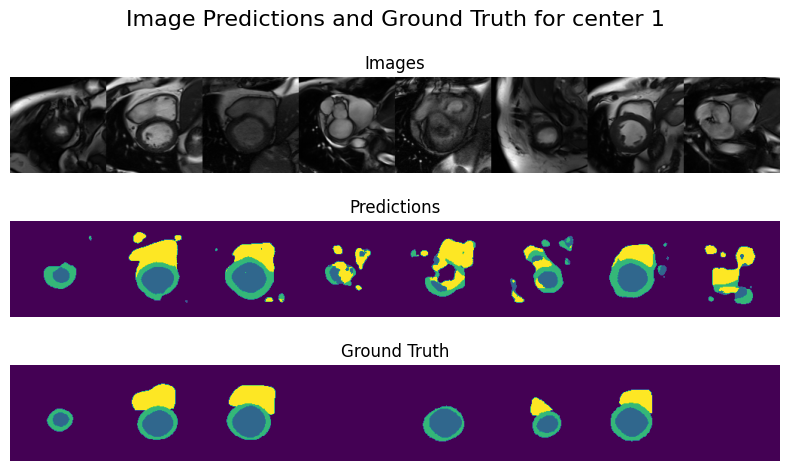

Centre: 2


100%|██████████| 74/74 [00:00<00:00, 81.95it/s]


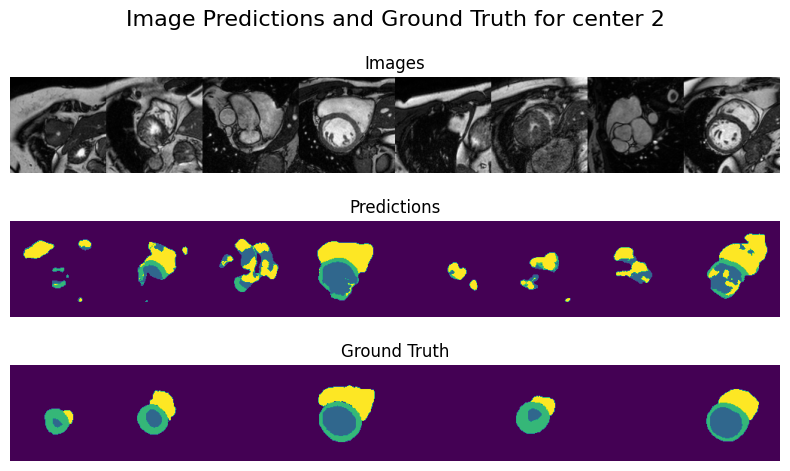

Centre: 3


100%|██████████| 51/51 [00:00<00:00, 75.16it/s]


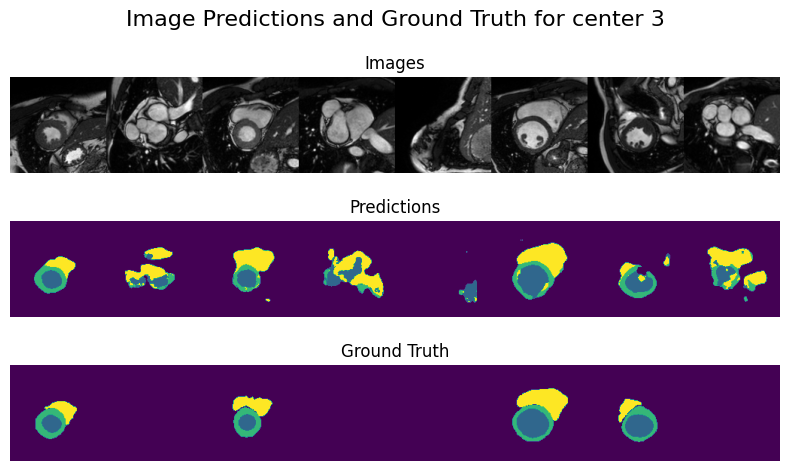

Centre: 4


100%|██████████| 47/47 [00:00<00:00, 69.23it/s]


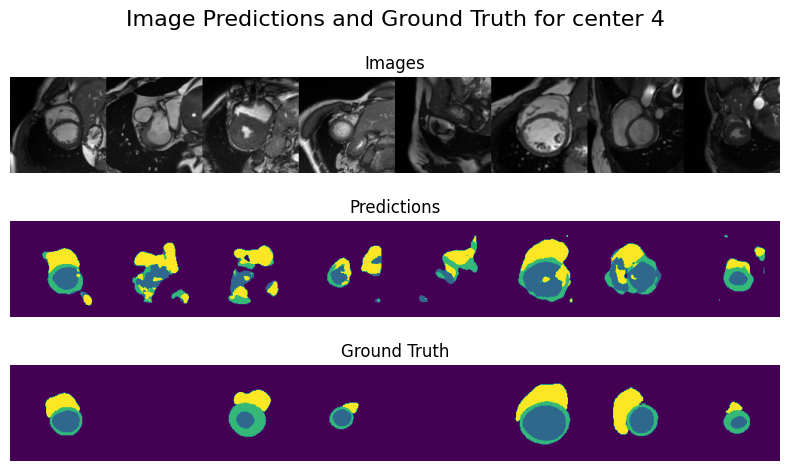

Centre: 5


100%|██████████| 50/50 [00:00<00:00, 69.96it/s]


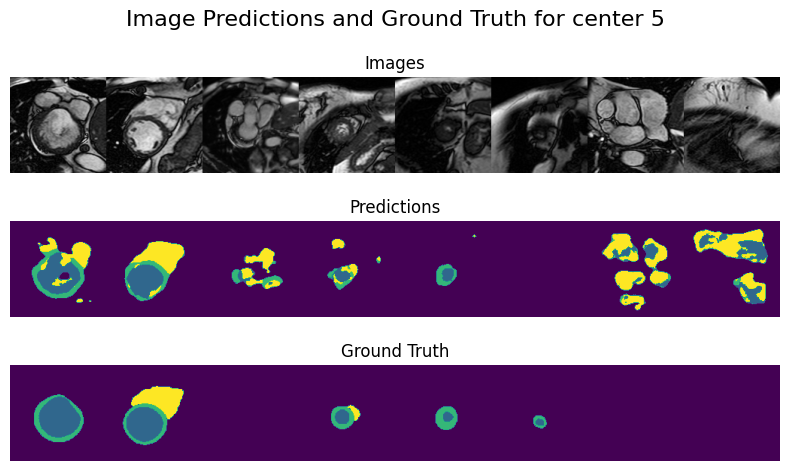

Centre: 6


100%|██████████| 76/76 [00:01<00:00, 71.98it/s]


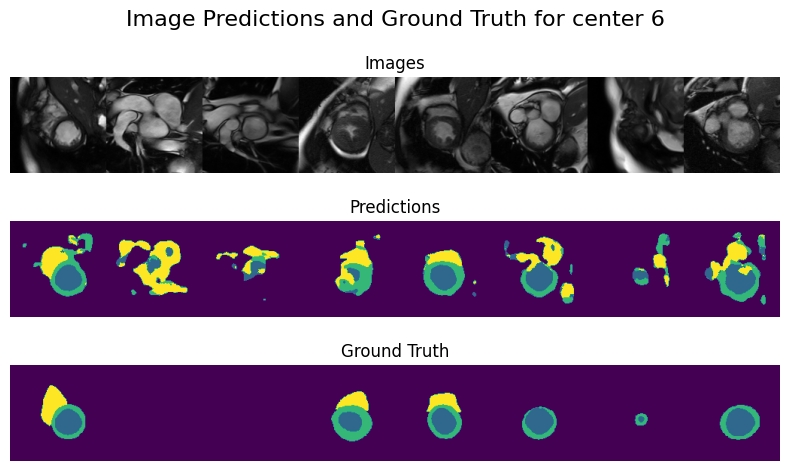

In [5]:
model = LitUnet.load_from_checkpoint("lightning_logs/version_38336/checkpoints/epoch=39-step=8880.ckpt")
model = LitUnet.load_from_checkpoint("lightning_logs/version_38336/checkpoints/epoch=29-step=6660-v3.ckpt")


batch_size = 8
for centre in range(1,7):
    print("Centre:", centre)
    val_dataset = Centre2DDataset(centre, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True ,num_workers=4)
    predict_and_display_examples(model, batch_size, val_loader, centre, seed=42)
